# Pipeline for WEST

This file is a brief tutorial for our proposed method Weighted Ensemble method for Spatial Transcriptomics (WEST). This tutorial contains the pipeline of the main functions of WEST, including the data preprocessing, the clustering, and the embedding, which can be further used for the low-dimensional visualization, trajectory inference and other application in the the analysis of spatial transcriptomics.

## 1. Package import

Load the requaired package for the pipeline. The detailed list of the required packages are presented in the read_me file. 

In [1]:
from WEST import west
import datatable as dt
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.10.2: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.10.2: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## 2. Read data

Load the data from dorsolateral prefrontal cortex tissue. The detailed introduction to the data can be found in the paper. The tissue used here is the one with index 151510. Create the WEST object, which only requires the count matrix (spot by gene) and the 2D spatial location matrix (spot by x,y coordinates).

In [2]:
#### Gene expression
X = dt.fread('../data/DLPFC/DLPFC_151673_X.csv')
#### Spatial location
S = dt.fread('../data/DLPFC/DLPFC_151673_S.csv')
#### Real cluster
true_cluster = pd.read_csv('../data/DLPFC/DLPFC_151673_cls.csv')
#### Construct west object


In [17]:
west_obj = west(X, S)

## 3. Train the model

The WEST will be trained after preprocessing. The parameters can be tuned are listed in the "**preprocess**" and "**train**" command. All the values listed here are the default values. 

In the "**preprocess**" part, "**screening**" indicates whether to screen the genes according to the expression level of each gene. 

In the "**train**" part, "**combine**" indicates whether to use the cluster result from SpaGCN to help construct the spot network in the SpaceFlow. According to our experience, setting "**combine**" to TRUE in the analysis of the sequencing-based data with a pre-established coordinate, such as Visium from 10X, can always have a better result. 

"**n_clusters**" and "**resolution**" control the cluster performance of the two sub-methods SpaGCN and SpaceFlow, respectively. These two parameters do not need to be known exactly, as long as in a reasonable region, since what WEST needs from these two methods are the low dimensional embeddings, instead of the clustering result. 

"**p**" and "**regularization**" are the parameters used to adjust the weight of spatial location over gene expression for SpaGCN and SpaceFlow, respectively. The spatial pattern will be stronger if these two values are greater. The analysis will be degenerated to using gene expression only, if these two parameters equal 0. 

In [18]:
%%capture captured_output
#### Preprocess
west_obj.preprocess(min_cells = 3, # number of minimum expressed spots for each gene 
                    n_top_genes = 3000, # number of remained genes with highest number of counts
                    n_comps = 100, # number of remained components in PCA
                    screening = False) # whether implements screening to genes
#### Training
west_obj.train(combine = True, # whether combine two ensemble methods
                n_clusters = 7, # number of clusters for SpaGCN
                resolution = 0.3, # resolution for SpaceFlow
                num_pcs = [100,100], # embedded dimensions for SpaGCN and SpaceFlow
                n_neighbors = 100, # number of neighbors for the weighted ensemble method
                p = 0.5, # spatial factor for SpaGCN
                regularization = 0.1, # spatial factor for SpaceFlow
                seed = 1234) # random seed

         Falling back to preprocessing with `sc.pp.pca` and default params.


## 4. Clustering

The training part returns a similar matrix of all the spots. The "**cluster**" command implement clustering using Leiden method based on the similarity between each pair of spots. The result can be adjusted using the parameter "**resolution**". The evaluation of the clustering performance is presented by calculating the adjusted rand index between the clustering result and the manually annotated labels. 

In [19]:
west_obj.cluster(resolution=0.8)
true_label = true_cluster["x"].to_numpy()
ARI = adjusted_rand_score(west_obj.adata.obs["WNN"], true_label) 
print("ARI: ", ARI)

ARI:  0.5163925948854207


In [20]:
print(adjusted_rand_score(west_obj.adata.obs["SpaceFlow"], true_label) )
print(west_obj.adata.obs["SpaceFlow"].unique())

0.37091466283703434
[0, 6, 3, 1, 5, 2, 4]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]


## 5. Get the embedding

The embedding part use command "**embedding**" to convert the similarity matrix to an arbitrary-dimensional embedding. The dimension of the embedding space can be adjusted through parameter "**dim**".

In [7]:
west_obj.embedding(dim = 50)

array([[ 2.96431930e-03, -7.13155333e-03,  5.10420654e-03, ...,
         5.62620668e-03, -3.54199936e-03,  5.11090967e-04],
       [ 7.74102672e-04,  1.32376043e-03,  1.45759129e-03, ...,
         2.51537306e-03, -5.22808918e-04,  9.37933014e-04],
       [ 4.00019036e-03, -6.42213719e-03, -2.17216584e-03, ...,
         1.21426179e-04,  2.09646037e-03,  3.89260713e-03],
       ...,
       [-3.59511302e-03, -1.62118349e-03, -5.79943553e-04, ...,
        -2.70036382e-03, -4.48985630e-03,  3.03898798e-04],
       [ 1.68175612e-03,  3.30860607e-03,  5.08849828e-03, ...,
        -3.47210862e-03, -3.22885108e-03, -1.49959538e-05],
       [-1.68404934e-03, -9.09064260e-04,  2.37359930e-03, ...,
         2.75299242e-04,  7.24018112e-04, -7.20466092e-05]])

## 6. Visualization

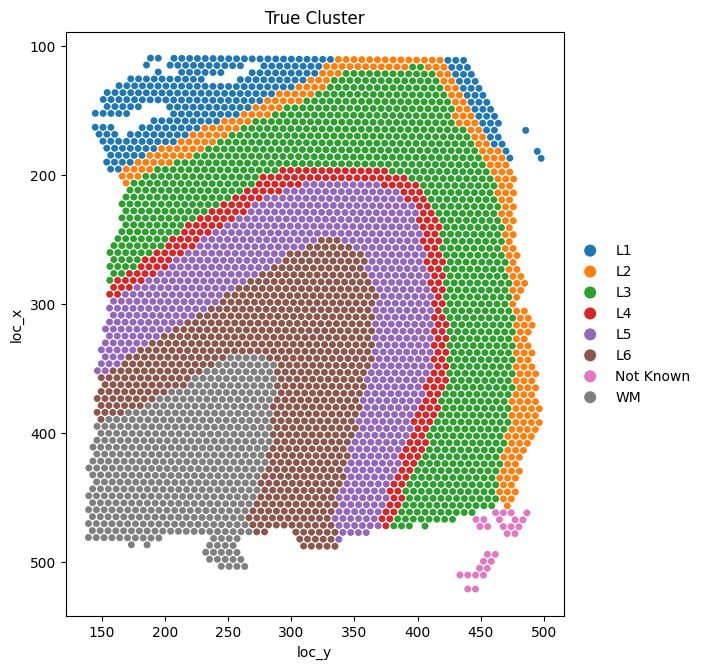

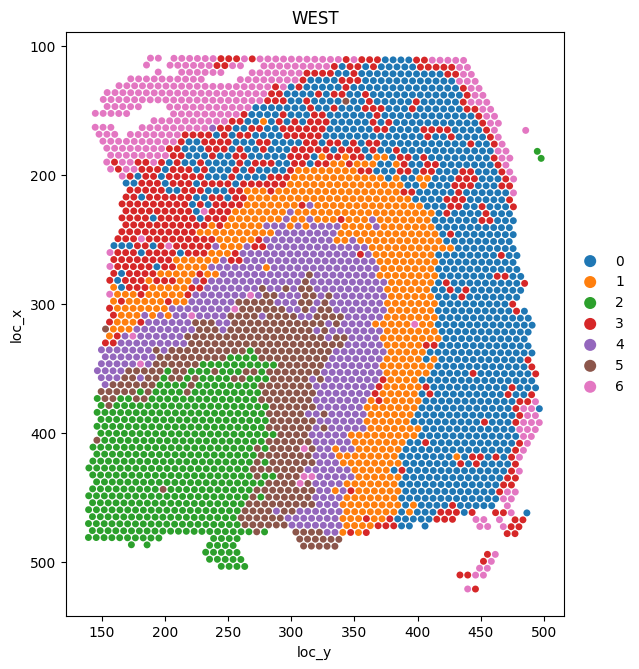

In [8]:
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]

plt.rcParams["figure.figsize"] = (6, 8)
num_celltype=len(np.unique(true_label))
west_obj.adata.uns["true cluster"]=list(plot_color[:num_celltype])
west_obj.adata.obs["true cluster"] = true_label
ax=sc.pl.scatter(west_obj.adata,alpha=1,x="loc_y",y="loc_x",color="true cluster",title="True Cluster",color_map=plot_color,show=False,size=100)    
ax.axes.invert_yaxis()
plt.show()    

num_celltype=len(west_obj.adata.obs["WNN"].unique())
west_obj.adata.uns["WEST"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(west_obj.adata,alpha=1,x="loc_y",y="loc_x",color="WNN",title="WEST",color_map=plot_color,show=False,size=100)    
ax.axes.invert_yaxis()
plt.show() 



## 7. PAGA Plot

PAGA is a tool to visualize the relationships between groups (or clusters) of cells in a way that provides insights into potential developmental trajectories, differentiation pathways, or other dynamic processes. The plot presented below is the PAGA plot of the result from WEST. It indicates a path-sequenced pattern consistent with the real tissue structure (from L1 to L6 to WM).

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

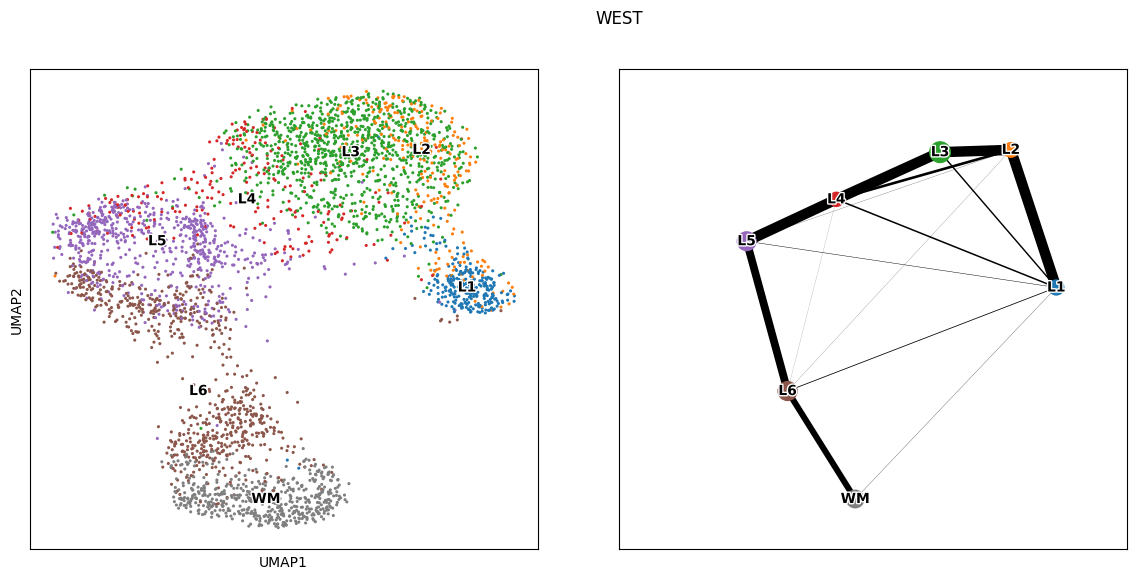

In [9]:
adata_new_plt = west_obj.adata[west_obj.adata.obs['true cluster']!='Not Known', ] # remove the unknown part
sc.tl.umap(adata_new_plt, neighbors_key='WNN')
sc.tl.paga(adata_new_plt, neighbors_key='WNN', groups='true cluster')
plt.rcParams["figure.figsize"] = (6,6)
sc.pl.paga_compare(adata_new_plt, legend_fontsize=10, frameon=True, size=20,
                   title="WEST", legend_fontoutline=2, show=False)